Used database: [github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/)<br>
First database: [kaggle.com/imdevskp/corona-virus-report](https://www.kaggle.com/imdevskp/corona-virus-report)<br>
Results of an analogous project: [life-xl.com/covid19.php](https://life-xl.com/covid19.php)

In [1]:
# Download the latest version of databases from the Internet and save to my disk

# !curl -o /media/l3m/LinuxFilesBig/1-datasets/COVID-19/COVID-19-confirmed.csv \
#          https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

# !curl -o /media/l3m/LinuxFilesBig/1-datasets/COVID-19/COVID-19-deaths.csv \
#            https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

# !curl -o /media/l3m/LinuxFilesBig/1-datasets/COVID-19/COVID-19-recovered.csv \
#          https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import math

PATH_DB = '/media/l3m/LinuxFilesBig/1-datasets/COVID-19/'

<br>

### Load and prepare data

In [3]:
# Load data from disk in Notebook
data_confirmed = pd.read_csv(PATH_DB+'COVID-19-confirmed.csv')
data_deaths = pd.read_csv(PATH_DB+'COVID-19-deaths.csv')
data_recovered = pd.read_csv(PATH_DB+'COVID-19-recovered.csv')

# rename some columns for convenience
for df in(data_confirmed, data_deaths, data_recovered):
    df.rename(columns={'Province/State': 'Province', 'Country/Region':'Country'}, inplace=True)

# check result
print(data_confirmed.shape)
print(data_deaths.shape)
print(data_recovered.shape)
data_confirmed.head(3)

(258, 77)
(258, 77)
(244, 77)


,Province,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,84,94,110,110,120,170,174,237,273,281
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,146,174,186,197,212,223,243,259,277,304
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,302,367,409,454,511,584,716,847,986,1171


In [4]:
# Transform tables to place Date in rows

data_confirmed = data_confirmed.set_index(['Province', 'Country', 'Lat', 'Long']) \
                               .stack() \
                               .reset_index() \
                               .rename(columns={'level_4':'Date', 0:'Confirmed'})

data_deaths = data_deaths.set_index(['Province', 'Country', 'Lat', 'Long']) \
                               .stack() \
                               .reset_index() \
                               .rename(columns={'level_4':'Date', 0:'Deaths'})

data_recovered = data_recovered.set_index(['Province', 'Country', 'Lat', 'Long']) \
                               .stack() \
                               .reset_index() \
                               .rename(columns={'level_4':'Date', 0:'Recovered'})

print(data_confirmed.shape)
data_confirmed.head(3)

(18834, 6)


,Province,Country,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.0,65.0,1/22/20,0
1,NaN,Afghanistan,33.0,65.0,1/23/20,0
2,NaN,Afghanistan,33.0,65.0,1/24/20,0


In [5]:
# Convirt content of 'Date'-column to date format

for df in (data_confirmed, data_deaths, data_recovered):
    df['Date'] = pd.to_datetime(df['Date'])

# check result
print(data_confirmed.shape)
print(data_deaths.shape)
print(data_recovered.shape)
data_confirmed.head(3)

(18834, 6)
(18834, 6)
(17812, 6)


,Province,Country,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.0,65.0,2020-01-22,0
1,NaN,Afghanistan,33.0,65.0,2020-01-23,0
2,NaN,Afghanistan,33.0,65.0,2020-01-24,0


<br>
At this moment data in recovered database are represented in a little different format. And since this data are not used furter, I ignore it.

In [6]:
# merge databases

assert len(data_confirmed) == len(data_deaths), \
    "DataFrames with have different sizes. Their merging can cause loss of data."

data_ac = data_confirmed.merge(data_deaths, on=['Province', 'Country', 'Lat', 'Long', 'Date'])

print(data_ac.shape)
data_ac.head(3)

(18834, 7)


,Province,Country,Lat,Long,Date,Confirmed,Deaths
0,NaN,Afghanistan,33.0,65.0,2020-01-22,0,0
1,NaN,Afghanistan,33.0,65.0,2020-01-23,0,0
2,NaN,Afghanistan,33.0,65.0,2020-01-24,0,0


In [7]:
# Combine data from different provinces for confirmed cases and deaths.
# Returned concised database with information only per countries.
# Datasets contain some difference in latitude and longitude,
# and since this information is insignificant for my goals, I omit them.

data_ac = data_ac.groupby(['Country', 'Date']) \
                 .agg({'Confirmed': 'sum',
                       'Deaths': 'sum'}) \
                 .reset_index()

print(data_ac.shape)
data_ac.head(3)

(13213, 4)


,Country,Date,Confirmed,Deaths
0,Afghanistan,2020-01-22,0,0
1,Afghanistan,2020-01-23,0,0
2,Afghanistan,2020-01-24,0,0


In [8]:
# Combine data from different provinces for recovered cases.
# Returned concised database with information only per countries.
# Datasets contain some difference in latitude and longitude,
# and since this information is insignificant for my goals, I omit them.

data_ac_recovered = data_recovered.groupby(['Country', 'Date']) \
                                  .agg({'Recovered': 'sum'}) \
                                  .reset_index()

print(data_ac_recovered.shape)
data_ac_recovered.head(3)

(13213, 3)


,Country,Date,Recovered
0,Afghanistan,2020-01-22,0
1,Afghanistan,2020-01-23,0
2,Afghanistan,2020-01-24,0


In [9]:
# Since concised databases have the same defining columns, we now can merge them in single datafram.
# Note, that in any of the previous operations there are no loss information about cases.

assert len(data_ac) == len(data_ac_recovered), \
    "DataFrames with have different sizes. Their merging can cause loss of data."

data_ac = data_ac.merge(data_ac_recovered, on=['Country', 'Date'])

print(data_ac.shape)
data_ac.head(3)

(13213, 5)


,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-22,0,0,0
1,Afghanistan,2020-01-23,0,0,0
2,Afghanistan,2020-01-24,0,0,0


In [10]:
# summarize data for world

data_world = data_ac.groupby('Date') \
                    .agg({'Country': lambda x: '_WORLD',
                          'Date': lambda x: x.iloc[0],
                          'Confirmed': 'sum',
                          'Deaths': 'sum',
                          'Recovered': 'sum'}).reset_index(drop=True)
data_world

,Country,Date,Confirmed,Deaths,Recovered
0,_WORLD,2020-01-22,555,17,28
1,_WORLD,2020-01-23,654,18,30
2,_WORLD,2020-01-24,941,26,36
3,_WORLD,2020-01-25,1434,42,39
4,_WORLD,2020-01-26,2118,56,52
...,...,...,...,...,...
68,_WORLD,2020-03-30,782365,37582,164566
69,_WORLD,2020-03-31,857487,42107,178034
70,_WORLD,2020-04-01,932605,46809,193177
71,_WORLD,2020-04-02,1013157,52983,210263


In [11]:
# Add data about the world at large in global dataframe

data_ac = pd.concat([data_ac, data_world]) \
            .reset_index(drop=True)

data_ac

,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-22,0,0,0
1,Afghanistan,2020-01-23,0,0,0
2,Afghanistan,2020-01-24,0,0,0
3,Afghanistan,2020-01-25,0,0,0
4,Afghanistan,2020-01-26,0,0,0
...,...,...,...,...,...
13281,_WORLD,2020-03-30,782365,37582,164566
13282,_WORLD,2020-03-31,857487,42107,178034
13283,_WORLD,2020-04-01,932605,46809,193177
13284,_WORLD,2020-04-02,1013157,52983,210263


<br>

### Countries with the highest numbers of confirmed cases

In [12]:
# Create additional DataFrame, containing only information about total cases

total_cases = data_ac.groupby('Country') \
                     .apply(lambda gr: gr.iloc[-1]) \
                     .reset_index(drop=True)

total_cases

,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-04-03,281,6,10
1,Albania,2020-04-03,304,17,89
2,Algeria,2020-04-03,1171,105,62
3,Andorra,2020-04-03,439,16,16
4,Angola,2020-04-03,8,2,1
...,...,...,...,...,...
177,Vietnam,2020-04-03,237,0,85
178,West Bank and Gaza,2020-04-03,194,1,21
179,Zambia,2020-04-03,39,1,2
180,Zimbabwe,2020-04-03,9,1,0


In [13]:
total_cases = total_cases.sort_values(by='Confirmed', ascending=False) \
                         .reset_index(drop=True)

# Show total statistics for world and countries with the highest numbers of confirmed cases
total_cases.head(60)

,Country,Date,Confirmed,Deaths,Recovered
0,_WORLD,2020-04-03,1095917,58787,225796
1,US,2020-04-03,275586,7087,9707
2,Italy,2020-04-03,119827,14681,19758
3,Spain,2020-04-03,119199,11198,30513
4,Germany,2020-04-03,91159,1275,24575
5,China,2020-04-03,82511,3326,76760
6,France,2020-04-03,65202,6520,14135
7,Iran,2020-04-03,53183,3294,17935
8,United Kingdom,2020-04-03,38689,3611,208
9,Turkey,2020-04-03,20921,425,484


<br>

### Create a table revealing of new cases

In [14]:
# Till now DataFrame contains total number of cases.
# Change it to the number of new cases per day (calculate it as difference b/w neighbouring rows)

data_dynamics = pd.concat([data_ac[['Country', 'Date']],
                           data_ac[['Confirmed', 'Deaths', 'Recovered']].diff()
                          ], axis='columns') \
                  .reset_index(drop=True)

print(data_dynamics.shape)
data_dynamics.head(3)

(13286, 5)


,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-22,NaN,NaN,NaN
1,Afghanistan,2020-01-23,0.0,0.0,0.0
2,Afghanistan,2020-01-24,0.0,0.0,0.0


In [15]:
# Now the first row (earliest day of observatopm) for each country contains garbage.
# So, delete the earliest data for each country

def delete_earliest_data(gr):
    gr.drop(gr.index[0], inplace=True)
    return gr
    
data_dynamics = data_dynamics.groupby(['Country']) \
                             .apply(delete_earliest_data) \
                             .reset_index(drop=True)

# Correct type of some columns back to int
data_dynamics[['Confirmed', 'Deaths', 'Recovered']] = \
    data_dynamics[['Confirmed', 'Deaths', 'Recovered']].astype('int')

print(data_dynamics.shape)
data_dynamics.head(3)

(13104, 5)


,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-23,0,0,0
1,Afghanistan,2020-01-24,0,0,0
2,Afghanistan,2020-01-25,0,0,0


<br>

### Create graphs with raw and smooth data

In the raw data occasionally a day of high revealing of infection adjoins with a day of low revealing. I suggest to smooth the data, taking for each day an average value between three adjacent days.

In [16]:
def smooth_df(df):
    
    def smooth_column_values(column):
        ls = list(column)
        lng = len(ls)

        smoothed_values = [] 
        
        smoothed_values.append(round((ls[0]*2 + ls[1]) / 3, 2))
        smoothed_values.extend([round((ls[i-1] + ls[i] + ls[i+1]) / 3, 2) for i in range(1, lng-1)])
        smoothed_values.append(round((ls[lng-2] + ls[lng-1]*2) / 3, 2))
    
        return smoothed_values

    df_smoothed = df.copy()
    for col_name in ['Confirmed', 'Deaths', 'Recovered']:
        df_smoothed[col_name] = smooth_column_values(df_smoothed[col_name])
        
    return df_smoothed

In [17]:
def build_graph(df, country_name, last_date, number_of_days=30):
    # extract DataFrame with data only about given country
    df_country = df[df['Country'] == country_name]
    
    # create DataFrame with smoothed data about given country
    df_smoothed = smooth_df(df_country)
    
    # calculate the first date for showing in the graph
    first_date = last_date + datetime.timedelta(days=-number_of_days+1)
    
    # reduce DataFrames, so they contain only data necessary for displaying
    df_country = df_country[(df_country['Date'] >= first_date) &
                            (df_country['Date'] <= last_date)]
    df_smoothed = df_smoothed[(df_smoothed['Date'] >= first_date) &
                             (df_smoothed['Date'] <= last_date)]

    # determine colors for graph
    if country_name == '_WORLD':
        colors_graph = ['#737373', '#808080']
        country_name = 'world'
    else:
        colors_graph = ['#C07800', '#D0810F']

    # create and show plot with raw data
    plt.title(country_name+' (raw data, cases/day)')
    plt.margins(x=0.003)
    plt.xticks(rotation='vertical')
    plt.grid(axis='y', color='limegreen', linewidth=0.15, zorder = 1)
    
    plt.bar(df_country['Date'].dt.strftime('%b-%d'), df_country['Confirmed'],
            width=1, color=colors_graph, zorder = 2)
   
    plt.show()


    # create and show plot with smoothed data
    plt.title(country_name+' (smoothed data, cases/day)')
    plt.margins(x=0.003)
    plt.xticks(rotation='vertical')
    plt.grid(axis='y', color='limegreen', linewidth=0.2, zorder = 1)
    
    plt.bar(df_country['Date'].dt.strftime('%b-%d'), df_smoothed['Confirmed'],
            width=1, color=colors_graph, zorder = 2)
   
    plt.show()

    return None

In [18]:
LAST_DATE_GLOBAL = data_ac['Date'].max()  # LAST_DATE_GLOBAL = datetime.datetime(2020, 3, 25)
NUMBER_OF_DAYS_GLOBAL = 30

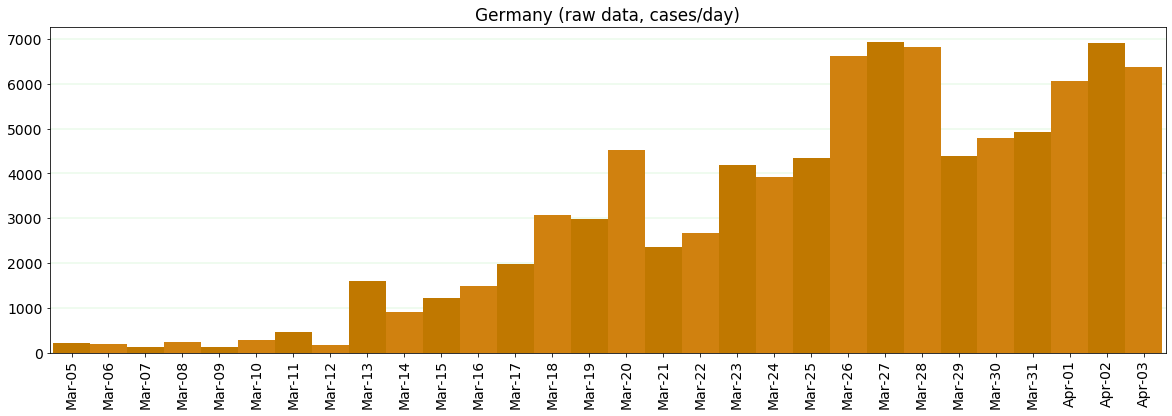

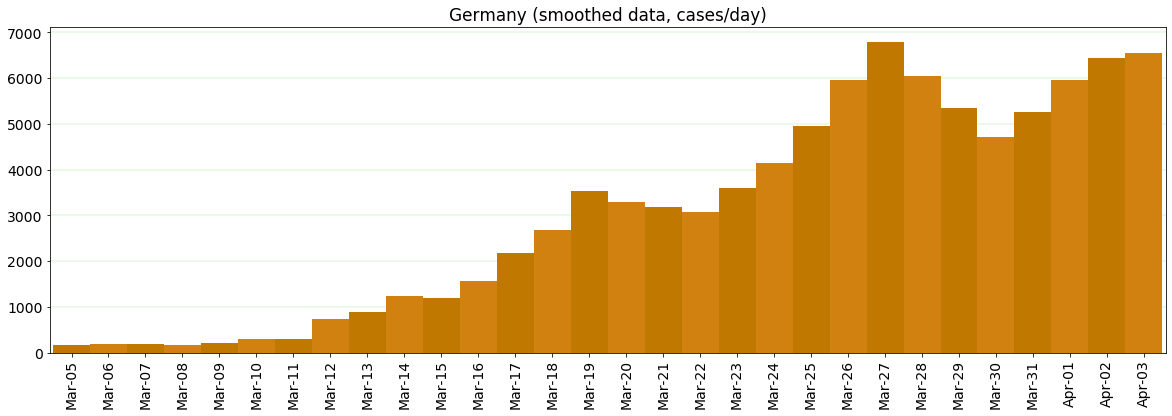

In [19]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.rcParams['font.size'] = 14

# for individual country\
country_name = 'Germany'
last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

build_graph(data_dynamics, country_name, last_date, number_of_days)

<br>

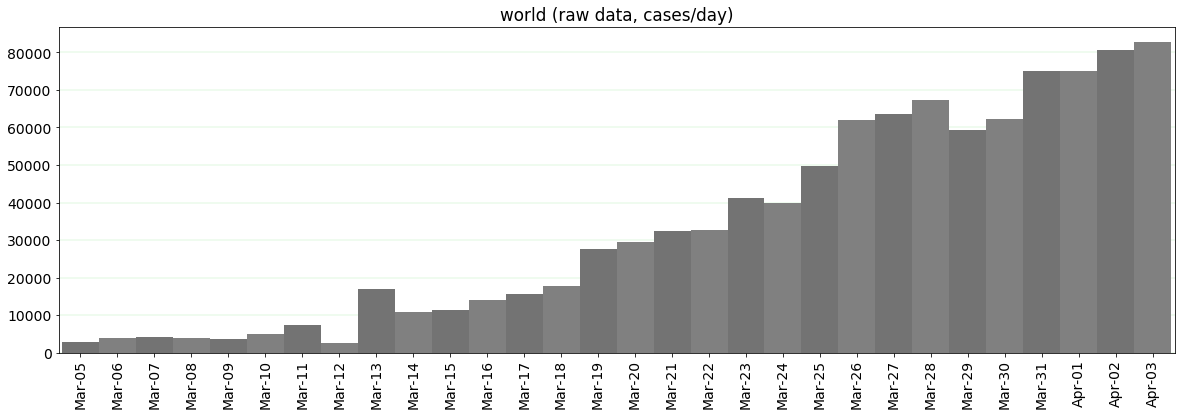

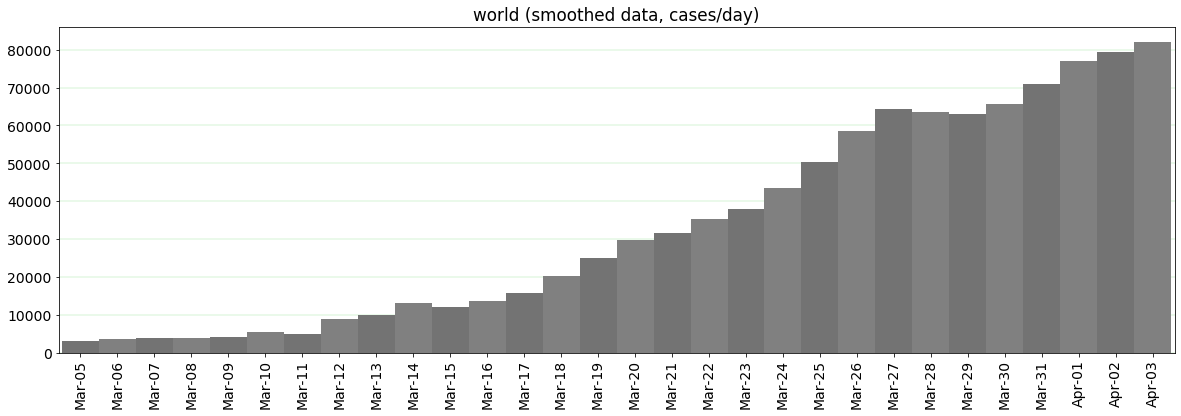

In [20]:
# for world
last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

build_graph(data_dynamics, '_WORLD', last_date, number_of_days)

<br>

### Comparison of several countries

In [21]:
# Service function for calculation of line frequency at the graph grid for logarithmic scale.

def calculate_logarithmic_ticks(min_value=1, max_value=10**10):
    ticks = []
    max_power = math.ceil(math.log10(max_value))
    min_power = math.floor(math.log10(min_value)) if min_value > 0 else 0
    
    for t in range(1, max_power+1):
        m = 10 ** t
        if m == 10:
            ticks.extend([2.5, 5, 7.5, 10])
        else:
            ticks.extend([m//4, m//2, m//4*3, m])

    ticks = list(filter(lambda n: (n >= min_value) & (n <= max_value), ticks))
    
    return ticks

In [22]:
plt.rcParams['figure.figsize'] = (20, 12)  # plt.rc('figure', figsize=(20, 8))
plt.rcParams['font.size'] = 14             # plt.rc('font', size=14)

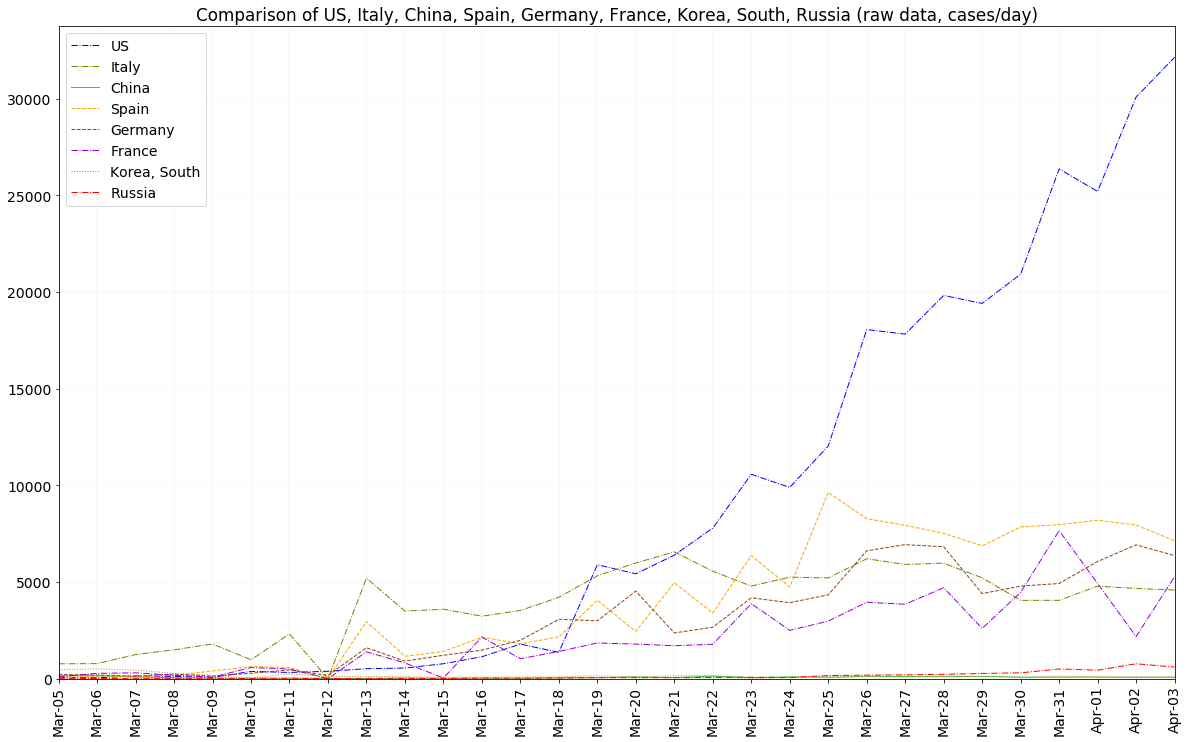

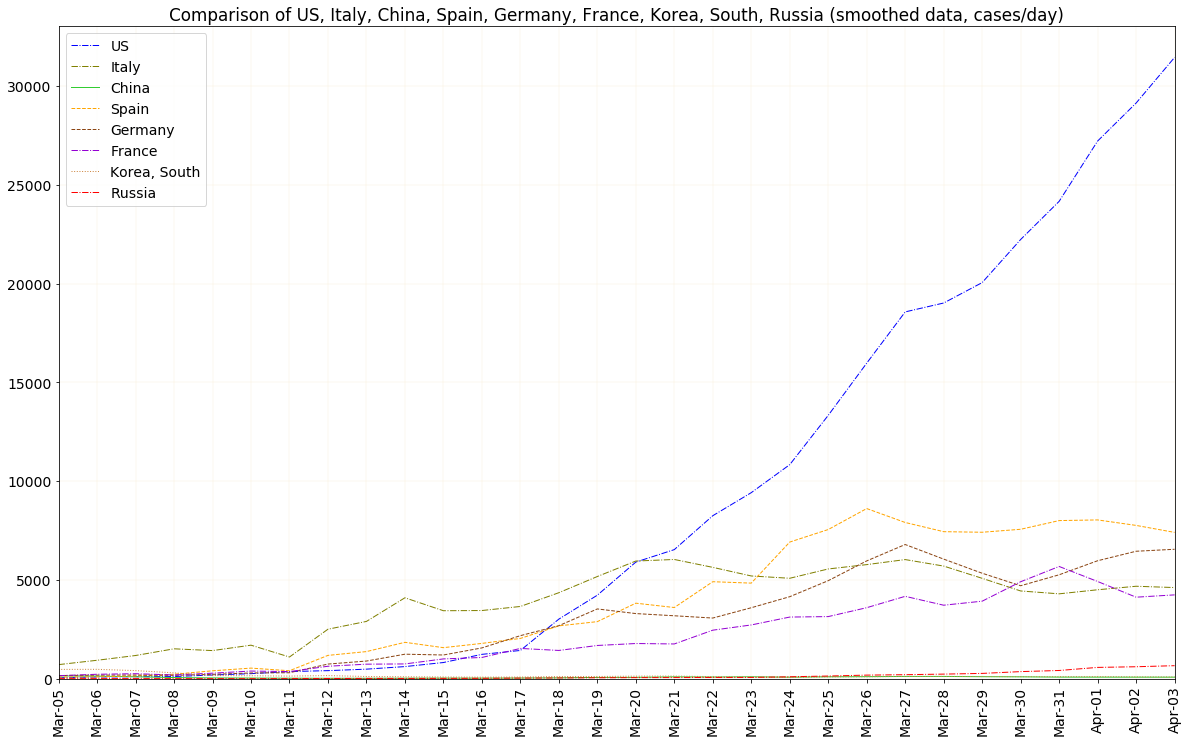

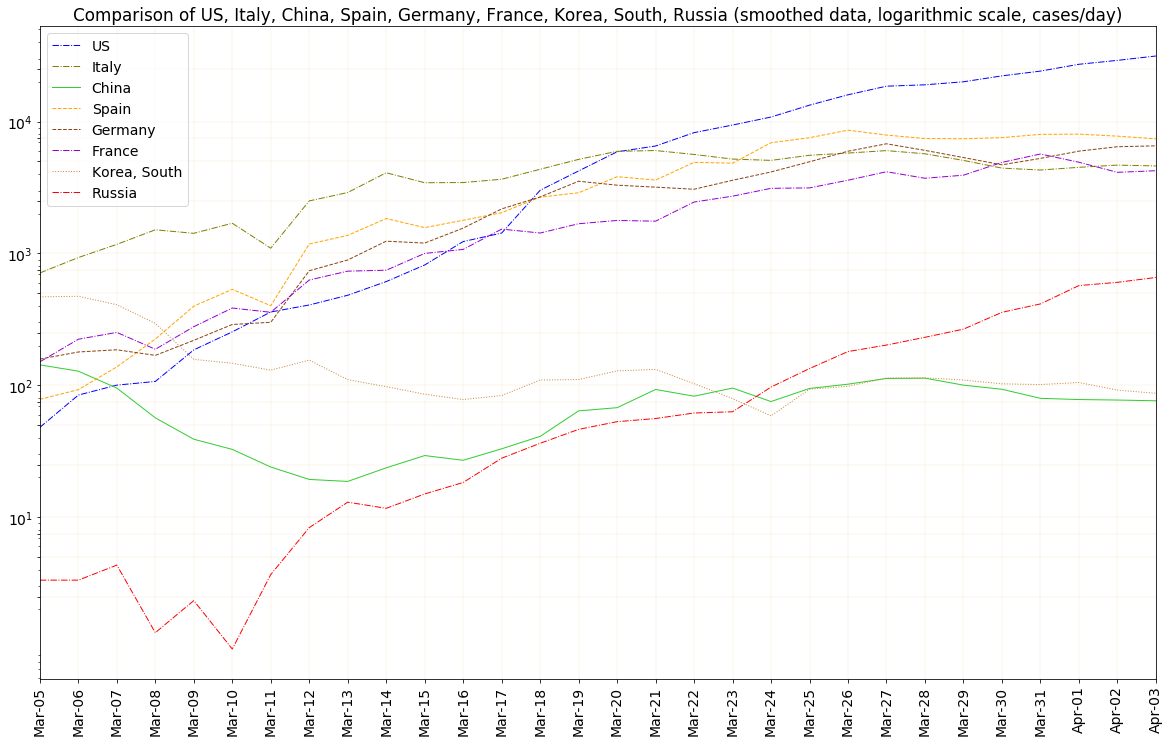

In [23]:
# for raw data, linear scale

countries = ['US', 'Italy', 'China', 'Spain', 'Germany', 'France', 'Korea, South', 'Russia']
colors = ['blue', 'olive', 'limegreen', 'orange', 'saddlebrown', 'darkviolet', 'peru', 'red']
styles = ['-.', '-.', '-', '--', '--', '-.', ':', '-.']

last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

# calculate the first date for showing in the graph
first_date = last_date + datetime.timedelta(days=-number_of_days+1)


# raw data
for i, country_name in enumerate(countries):
    country_graph = data_dynamics[(data_dynamics['Country'] == country_name) &
                                  (data_dynamics['Date'] >= first_date) &
                                  (data_dynamics['Date'] <= last_date)]
    plt.plot(country_graph['Date'].dt.strftime('%b-%d'), country_graph['Confirmed'],
             color=colors[i], linestyle=styles[i], linewidth=1, label=country_name)

plt.xticks(rotation='vertical')
plt.grid(color='wheat', linewidth=0.2)
plt.legend(loc='upper left')
    
plt.title(f"Comparison of {', '.join(countries)} (raw data, cases/day)")
plt.margins(x=0)
plt.ylim(0)

plt.show()


# smoothed data
for i, country_name in enumerate(countries):
    smoothed_graph = smooth_df(data_dynamics[data_dynamics['Country'] == country_name])
    smoothed_graph = smoothed_graph[(smoothed_graph['Date'] >= first_date) &
                                    (smoothed_graph['Date'] <= last_date)]                 
                                            
    plt.plot(smoothed_graph['Date'].dt.strftime('%b-%d'), smoothed_graph['Confirmed'],
             color=colors[i], linestyle=styles[i], linewidth=1, label=country_name)

plt.xticks(rotation='vertical')
plt.grid(color='wheat', linewidth=0.2)
plt.legend(loc='upper left')

plt.title(f"Comparison of {', '.join(countries)} (smoothed data, cases/day)")
plt.margins(x=0)
plt.ylim(0)

plt.show()



# smoothed data, logarithmic scale
rate_min = math.inf  # service variables, don't change them
rate_max = 0

for i, country_name in enumerate(countries):
    smoothed_graph = smooth_df(data_dynamics[data_dynamics['Country'] == country_name])
    smoothed_graph = smoothed_graph[(smoothed_graph['Date'] >= first_date) &
                                    (smoothed_graph['Date'] <= last_date)]   
    
    rate_min_current = smoothed_graph['Confirmed'].min()
    if rate_min_current < rate_min:
        rate_min = rate_min_current
        
    rate_max_current = smoothed_graph['Confirmed'].max()
    if rate_max_current > rate_max:
        rate_max = rate_max_current
    
    plt.plot(smoothed_graph['Date'].dt.strftime('%b-%d'), smoothed_graph['Confirmed'],
             color=colors[i], linestyle=styles[i], linewidth=1, label=country_name)

plt.xticks(rotation='vertical')
plt.grid(color='wheat', linewidth=0.2)
plt.legend(loc='upper left')

plt.title(f"Comparison of {', '.join(countries)}"
           " (smoothed data, logarithmic scale, cases/day)")

plt.margins(x=0)

plt.grid(color='wheat', linewidth=0.25)

plt.yscale('log')
labels_y = calculate_logarithmic_ticks(rate_min, rate_max)
plt.yticks(labels_y)

plt.show()

<br>

### Comparison of dynamics after the first n confirmed cases
(*beginning from the day than this limit was achieved*)<br>
Caution: don't use China for this conparison since the table doesn't contain information about the first cases in this country.

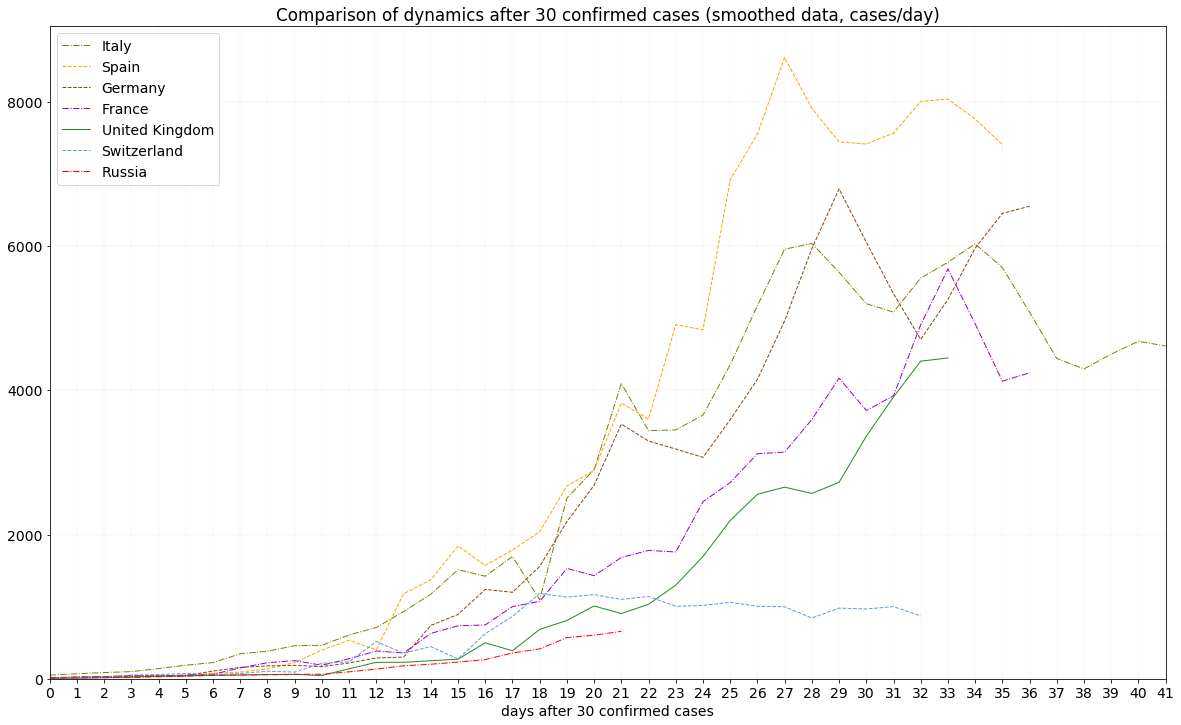

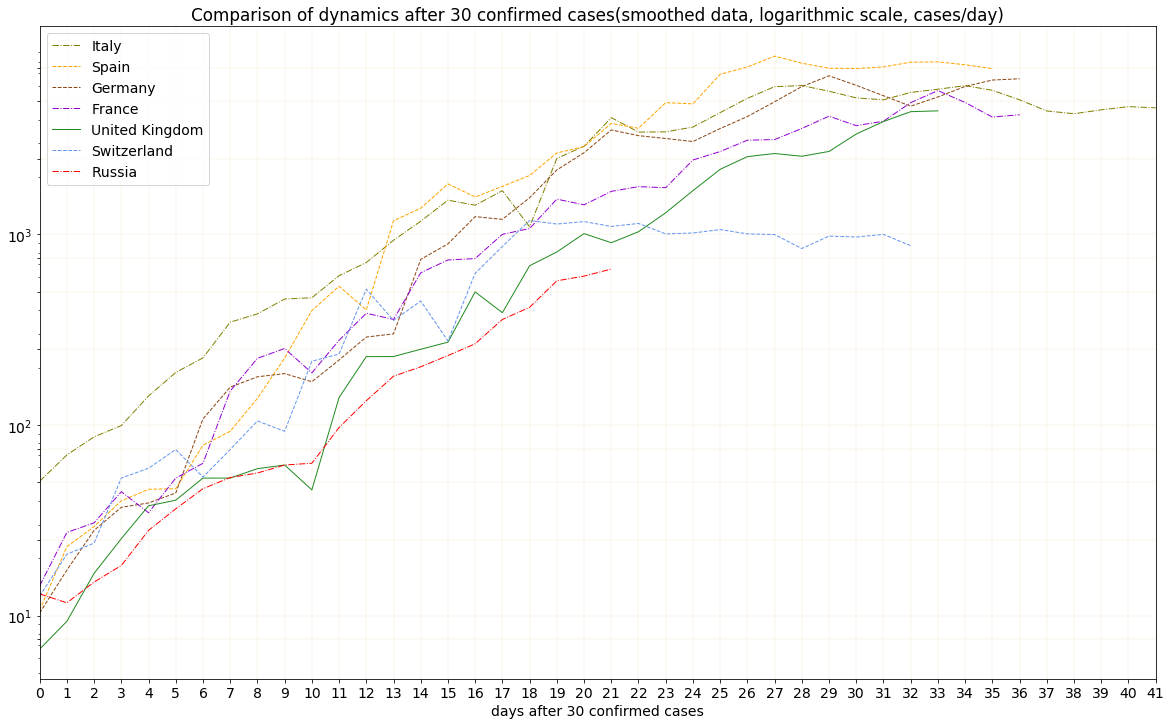

In [24]:
# used smoothed data, linear scale

countries = ['Italy', 'Spain', 'Germany', 'France', 'United Kingdom', 'Switzerland', 'Russia']
colors = ['olive', 'orange', 'saddlebrown', 'darkviolet', 'forestgreen', 'cornflowerblue', 'red']
styles = ['-.', '--', '--', '-.', '-', '--', '-.']

MIN_LIMIT = 30

max_lng = 0  # service variable, don't change it


# linear scale
for i, country in enumerate(countries):
    min_date = data_ac[(data_ac['Country'] == country) & ((data_ac['Confirmed'] >= MIN_LIMIT))]['Date'].min()
    
    smoothed_graph = smooth_df(data_dynamics[data_dynamics['Country'] == country])
    smoothed_graph = smoothed_graph[smoothed_graph['Date'] >= min_date].reset_index(drop=True)
    if len(smoothed_graph) > max_lng:
        max_lng = len(smoothed_graph)
    plt.plot(smoothed_graph.index, smoothed_graph['Confirmed'],
             color=colors[i], linestyle=styles[i], linewidth=1, label=country)
    
plt.margins(x=0)
plt.ylim(0)

labels = range(max_lng)
plt.xticks(labels)
plt.grid(color='wheat', linewidth=0.2)

plt.title(f'Comparison of dynamics after {MIN_LIMIT} confirmed cases (smoothed data, cases/day)')
plt.legend()
plt.xlabel(f'days after {MIN_LIMIT} confirmed cases')

plt.show()


# logarithmic scale
rate_min = math.inf
rate_max = 0

for i, country in enumerate(countries):
    min_date = data_ac[(data_ac['Country'] == country) & ((data_ac['Confirmed'] >= MIN_LIMIT))]['Date'].min()
    
    country_graph = smooth_df(data_dynamics[data_dynamics['Country'] == country])
    country_graph = country_graph[country_graph['Date'] >= min_date].reset_index(drop=True)
        
    rate_min_current = country_graph['Confirmed'].min()
    if rate_min_current < rate_min:
        rate_min = rate_min_current
        
    rate_max_current = country_graph['Confirmed'].max()
    if rate_max_current > rate_max:
        rate_max = rate_max_current
        
    plt.plot(country_graph.index, country_graph['Confirmed'],
             color=colors[i], linestyle=styles[i], linewidth=1, label=country)
    
plt.margins(x=0)
plt.yscale('log')

labels = range(max_lng)
plt.xticks(labels)

plt.title(f'Comparison of dynamics after {MIN_LIMIT} confirmed cases' \
           '(smoothed data, logarithmic scale, cases/day)')
plt.legend()
plt.xlabel(f'days after {MIN_LIMIT} confirmed cases')

plt.grid(color='wheat', linewidth=0.25)

labels_y = calculate_logarithmic_ticks(rate_min, rate_max)
plt.yticks(labels_y)

plt.show()

<br>

In [25]:
# countries = ['Italy', 'Spain', 'Germany', 'France', 'United Kingdom', 'Switzerland', 'Russia']
# colors = ['olive', 'orange', 'saddlebrown', 'darkviolet', 'forestgreen', 'cornflowerblue', 'red']
# styles = ['-.', '--', '--', '-.', '-', '--', '-.']

# countries = ['Korea, South', 'Malaysia', 'Japan', 'Thailand', 'Indonesia', 'India', 'Russia']
# colors = ['peru', 'darkolivegreen', 'gold', 'slateblue', 'rebeccapurple', 'yellowgreen', 'red']
# styles = ['--', ':', '-', '--', '-.', '-', '-.']

# countries = ['US', 'Canada', 'Brazil', 'Chile', 'Ecuador', 'Mexico', 'Russia']
# colors = ['blue', 'darkgray', 'limegreen', 'darkgoldenrod', 'orange', 'gold', 'red']
# styles = ['-.', ':', '-', '--', '-.', '-', '-.']

# countries = ['US', 'Italy', 'China', 'Spain', 'Germany', 'France', 'Korea, South']
# colors = ['blue', 'olive', 'limegreen', 'orange', 'saddlebrown', 'darkviolet', 'peru']
# styles = ['-.', '-.', '-', '--', '--', '-.', ':']